In [1]:
using Distributions

First we'll make some data, and try to see how well the regression recovers the parameters.

In [2]:
# Generate some data

a = 0.45
b = 4.2

n_samples = 100

xs = zeros(n_samples)
ys = zeros(n_samples)

for i in 1:n_samples
    x = rand(Normal())
    xs[i] = x
    ys[i] = a * x + b + rand(Normal(0, 0.5))
end

In [3]:
using Plots

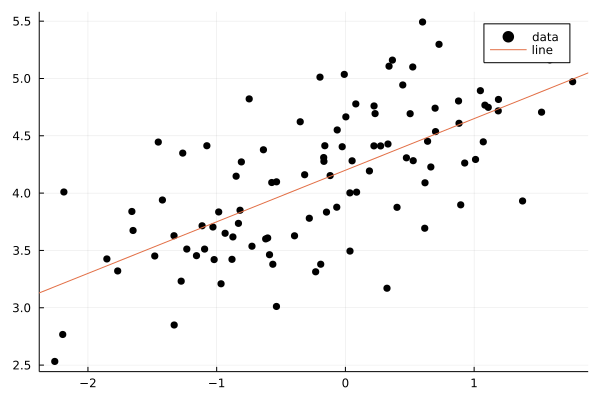

In [17]:
p = scatter(xs, ys, label="data", color="black")

Plots.abline!(p, a, b, label="line")

In [18]:
savefig(p, "figures/linear_data.pdf")

# Frequentist model

We'll try to fit a small model, in frequentist and bayesian case.

In [8]:
using GLM

In [9]:
using DataFrames

In [10]:
dataframe = DataFrame(:x => xs, :y => ys) |> df -> sort(df, :x)

,x,y
,Float64,Float64
1,-2.25774,2.53209
2,-2.19593,2.76718
3,-2.18693,4.00993
4,-1.85292,3.42598
5,-1.76892,3.32125
6,-1.65873,3.83991
7,-1.64958,3.67417
8,-1.481,3.45164
9,-1.45366,4.44531


In [11]:
lm_freq = lm(@formula(y ~ 1 + x), dataframe)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  4.20551    0.0477644  88.05    <1e-94   4.11073    4.3003
x            0.440991   0.0511742   8.62    <1e-12   0.339437   0.542544
────────────────────────────────────────────────────────────────────────

To look how our model looks, we'll plot predictions.

In [12]:
μ_y = predict(lm_freq, dataframe)

100-element Vector{Union{Missing, Float64}}:
 3.209871218341992
 3.237127293699415
 3.2410991923749664
 3.388391815836065
 3.425436679239473
 3.4740269307304588
 3.4780655779745846
 3.552404626017229
 3.564463043083359
 3.5786046667014793
 3.618386883261468
 3.618940662946789
 3.642929195431502
 ⋮
 4.614210838342739
 4.651343461674706
 4.667927455272675
 4.6778175770303845
 4.683475455521945
 4.694904053382718
 4.729112622643219
 4.729854655467767
 4.812431447754301
 4.877500817924993
 4.905784893707447
 4.984007629511067

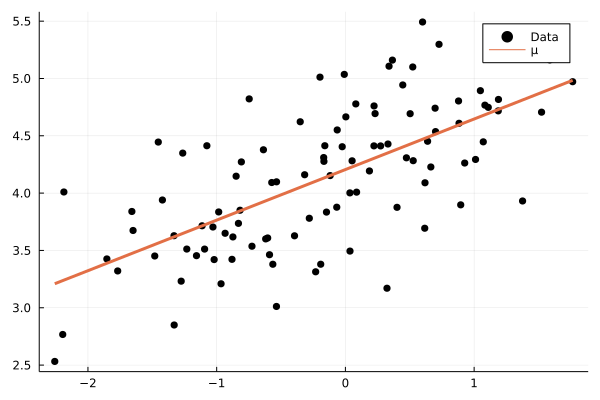

In [13]:
p = scatter(dataframe[!,:x], dataframe[!,:y], label="Data", color="black")
plot!(p, dataframe[!,:x], μ_y, label="μ", w=3)

In [19]:
conf_int = predict(lm_freq, dataframe, interval=:confidence);

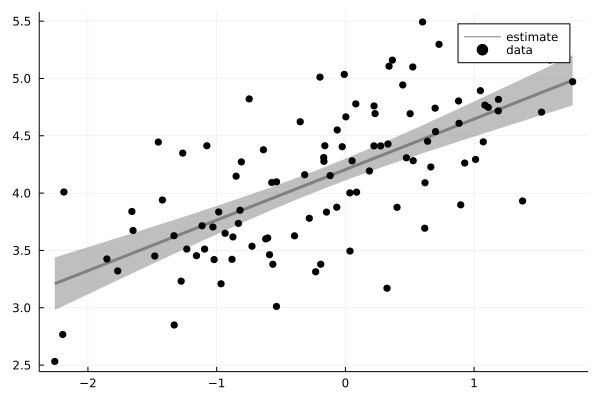

In [20]:
plot(dataframe[!,:x], μ_y, ribbon=(conf_int[!,:upper] .- μ_y,
                                   μ_y .- conf_int[!,:lower]),
     color="grey", label="estimate", w=3)
scatter!(dataframe[!,:x], dataframe[!,:y], label="data", color="black")
# plot!(dataframe[!,:x], conf_int[!,:upper], color="grey", label=missing)
# plot!(dataframe[!,:x], conf_int[!,:lower], color="grey", label=missing)

In [21]:
pred_int = predict(lm_freq, dataframe, interval=:prediction);

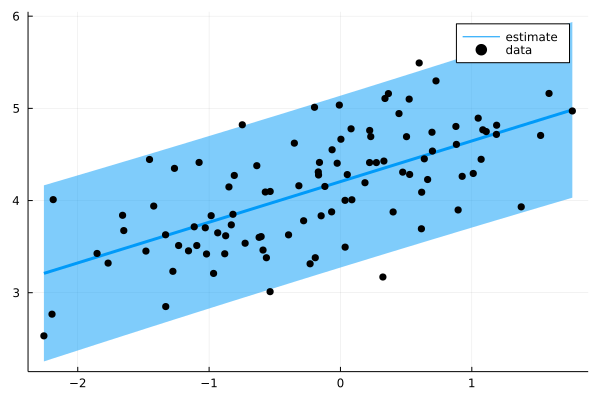

In [22]:
p = plot(dataframe[!,:x], μ_y, ribbon=(pred_int[!,:upper] .- μ_y,
                                       μ_y .- pred_int[!,:lower]),
      label="estimate", w=3)

scatter!(p, dataframe[!,:x], dataframe[!,:y], label="data", color="black")
# plot!(dataframe[!,:x], pred_int[!,:lower], color="green", label=missing)
# plot!(dataframe[!,:x], pred_int[!,:upper], color="green", label=missing)

In [23]:
savefig(p, "figures/linear_prediction_interval.pdf")

We can see that the *prediction intervals* include the error around the line. But do they include the error *in* the lines (that we see the confidence intervals have different widths!)

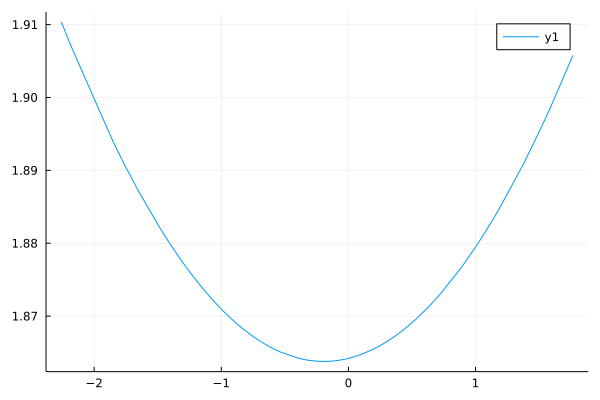

In [24]:
plot(dataframe[!,:x], pred_int[!,:upper] .- pred_int[!,:lower])

The answer is yes. They also include the uncertainty as to where the line is!

# Bayesian model

In [25]:
using Turing

In [31]:
@model function linear(xs, ys)
    l = length(xs)
    
    # Priors for lines
    a ~ Normal(0, 1)
    b ~ Normal(0, 3)
    
    # Prior for variance of points with line
    sigma ~ Exponential(0.2)
    
    for i in 1:l
        expected = a * xs[i] + b
        ys[i] ~ Normal(expected, sigma)
    end
    
    return ys
end

linear (generic function with 2 methods)

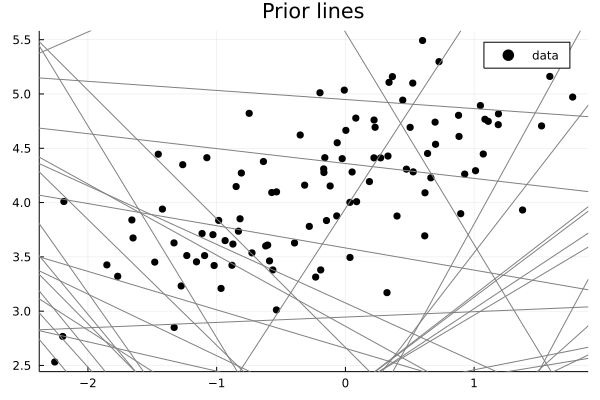

In [35]:
# Sampling from prior

N = 100
as = rand(Normal(0, 1), N)
bs = rand(Normal(0, 3), N)

p = scatter(dataframe[!,:x], dataframe[!,:y], label="data", title="Prior lines",
    color="black")
for i in 1:N
    Plots.abline!(p, as[i], bs[i], label=missing, color="gray")
end

p

In [36]:
savefig(p, "figures/linear_prior_lines.pdf")

In [34]:
model = linear(xs, ys)
chain = sample(model, NUTS(0.65), 2000)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 11.74 seconds
Compute duration  = 11.74 seconds
parameters        = a, b, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           a    0.4389    0.0514     0.0011    0.0009   2389.9745    0.9998    ⋯
           b    4.2053    0.0468     0.0010    0.0011   1925.4337    1.0005    ⋯
       sigma    0.4668    0.0328     0.0007    0.0008   1831.5166    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75

In [37]:
using StatsPlots

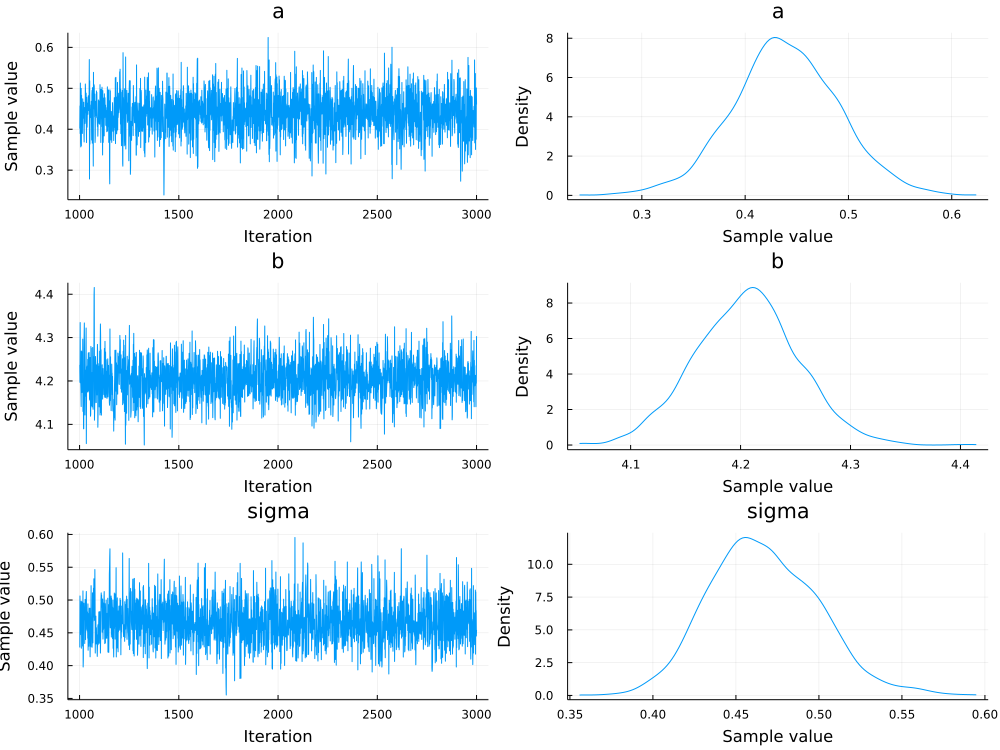

In [38]:
plot(chain)

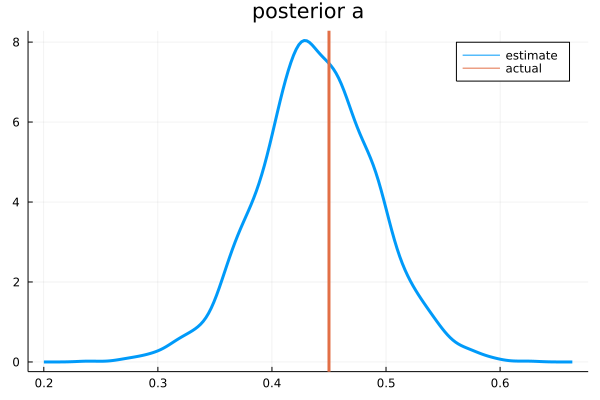

In [53]:
p_a = density(chain[:a], label="estimate", title="posterior a", w=3)

vline!(p_a, [0.45], label="actual", w=3)

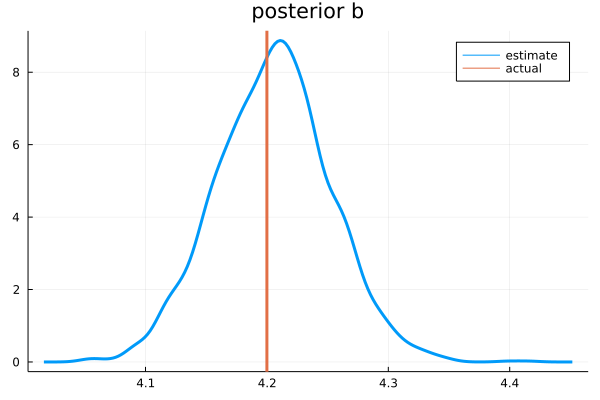

In [54]:
p_b = density(chain[:b], label="estimate", title="posterior b", w=3)

vline!(p_b, [4.2], label="actual", w=3)

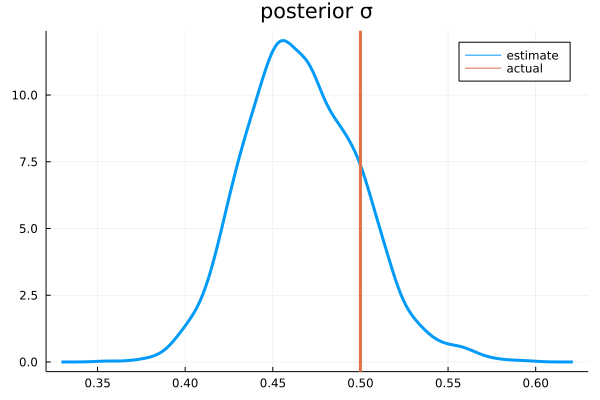

In [55]:
p_σ = density(chain[:sigma], label="estimate", title="posterior σ", w=3)

vline!(p_σ, [0.5], label="actual", w=3)

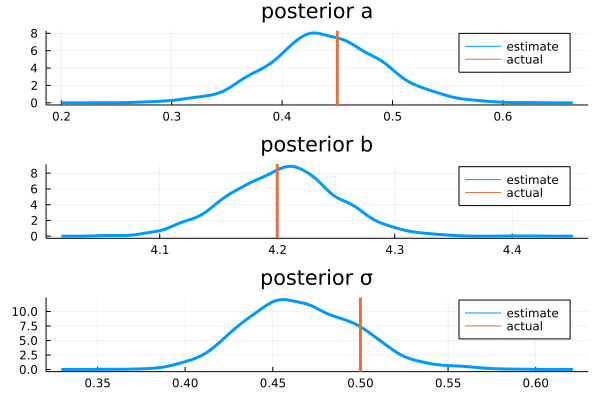

In [60]:
p_posteriors = plot(p_a, p_b, p_σ, layout=(3,1))

In [62]:
savefig(p_posteriors, "figures/posterior_parameters.pdf")

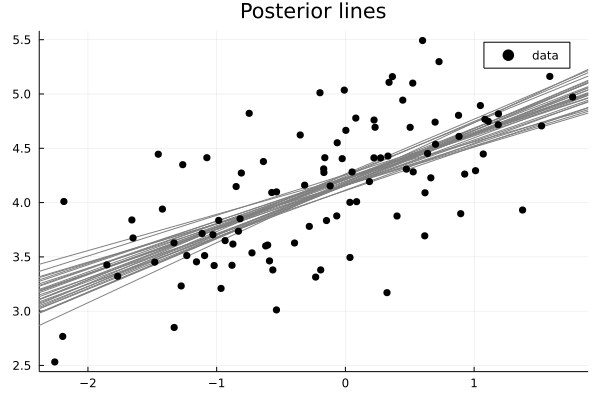

In [63]:
p = plot(title="Posterior lines")

for i in 1:30
    a = rand(chain[:a])
    b = rand(chain[:b])
    
    Plots.abline!(p, a, b,
        label=missing,
        color="gray")
end

scatter!(p, dataframe[!, :x], dataframe[!,:y], color="black", label="data")

p

In [64]:
savefig(p, "figures/posterior_lines.pdf")

We see we get a distribution of many lines, which show the uncertainty. 
Now, how do you make predictions with such a model? 

# Bayesian predictions

In [65]:
# Prediction
model = linear([0.0, 1.0], [missing, missing])

prediction = predict(model, chain)

Chains MCMC chain (2000×2×1 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 1
Samples per chain = 2000
parameters        = ys[1], ys[2]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

       ys[1]    4.2235    0.4924     0.0110    0.0099   1932.8202    1.0021
       ys[2]    4.6552    0.4745     0.0106    0.0104   2055.9312    0.9995

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       ys[1]    3.2498    3.8971    4.2203    4.5442    5.1521
       ys[2]    3.7398    4.3284    4.6615    4.9755    5.5919


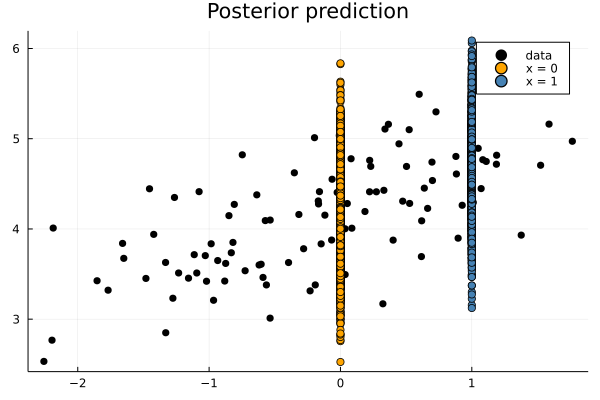

In [66]:
p = scatter(dataframe[!, :x], dataframe[!,:y], color="black", label="data",
    title="Posterior prediction")

scatter!(repeat([0.0], 2000), prediction["ys[1]"], label="x = 0", color="orange")
scatter!(repeat([1.0], 2000), prediction["ys[2]"], label="x = 1", color="steelblue")

In [67]:
savefig(p, "figures/predictions.pdf")

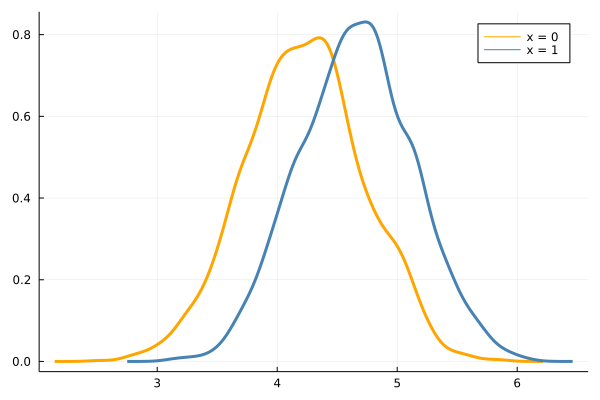

In [69]:
p_predictions = density(prediction["ys[1]"], label="x = 0", color="orange", w=3)
density!(p_predictions, prediction["ys[2]"], label="x = 1", color="steelblue", w=3)

In [70]:
savefig(p_predictions, "figures/prediction_distrubtions.pdf")

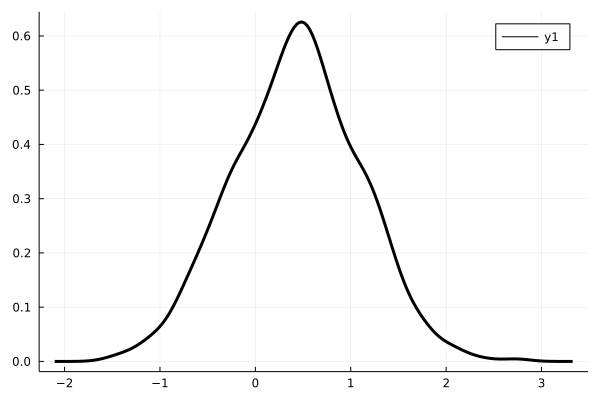

In [71]:
p = density(prediction["ys[2]"] .- prediction["ys[1]"], color="black", w=3)

In [72]:
savefig(p, "figures/prediction_difference.pdf")